# Customer Retention Analysis: Telco Churn Dataset
### Understanding customer behavior and identifying churn drivers for a telecommunications company

---

## Notebook 04: Insights and Recommendations
This notebook translates findings from the exploratory data analysis into actionable business insights and recommendations aimed at reducing customer churn. We identify the key drivers influencing churn and outline data-driven strategies to improve customer retention and long-term loyalty.

---

## Insights & Recommendations: Table of Contents
- [4.0 Churn Drivers & Insights](#40-churn-drivers--insights)
    - [4.1 Contract & Billing-Related Drivers](#41-contract--billing-related-drivers)
    - [4.2 Financial & Loyalty Drivers](#42-financial--loyalty-drivers)
    - [4.3 Internet Service Drivers](#43-internet-service-drivers)
    - [4.4 Key Churn Drivers Summary](#44-key-churn-drivers-summary)
    - [4.5 Recommendations](#45-recommendations)
    - [4.6 Business Impact Summary](#46-business-impact-summary)

In [ ]:
# Import libraries
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load Data
ENCODED_DATA_PATH = Path('../data/encoded_telco_churn_data.csv')
READABLE_DATA_PATH = Path('../data/readable_telco_churn_data.csv')
df = pd.read_csv(ENCODED_DATA_PATH)
df_readable = pd.read_csv(READABLE_DATA_PATH)

## 4.0 Churn Drivers & Insights <a class="anchor" id="40-churn-drivers--insights"></a>

Exploring Telco data has revealed insights about its customers, services, contracts, payment methods and amounts, and customer loyalty. 
This section consolidates findings from the exploratory analysis to identify the primary factors contributing to customer churn.
The analysis focuses on service usage, contract characteristics, financial engagement, and customer tenure to highlight where retention risk is most concentrated.

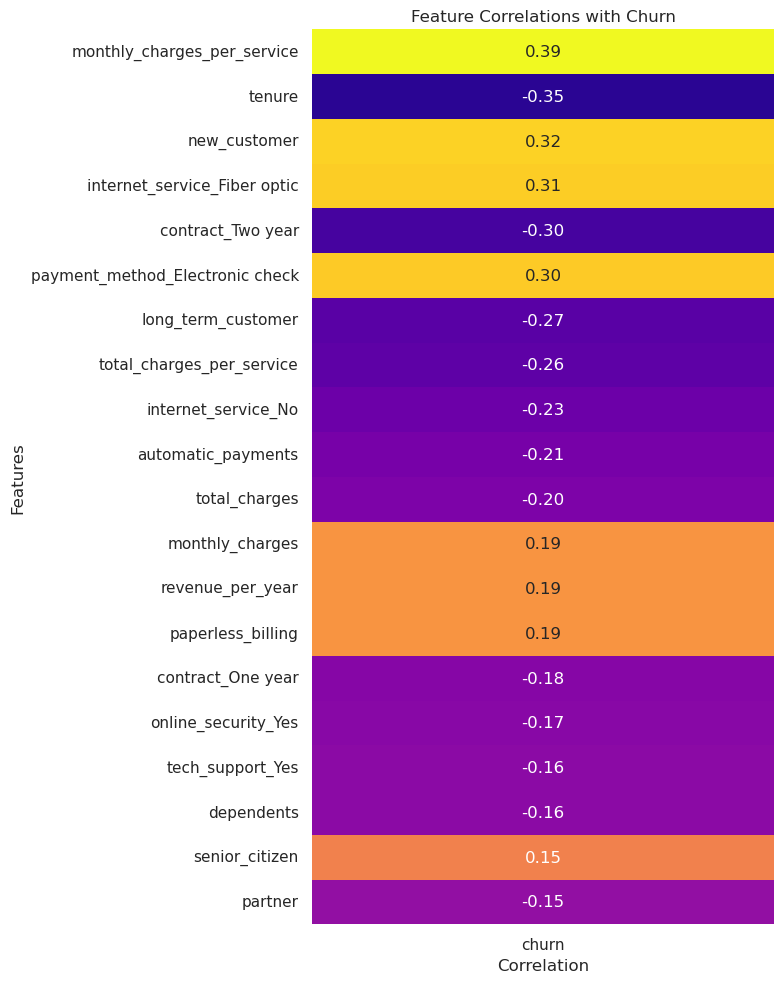

In [ ]:

corr = df.corr(numeric_only=True) # Create correlation matrix of endoced numerical data

# Filter out redundant features and churn
redundant = ['online_security_No internet service',
             'online_backup_No internet service',
             'device_protection_No internet service',
             'tech_support_No internet service',
             'streaming_tv_No internet service',
             'streaming_movies_No internet service',
             'tenure_years', 
             'avg_monthly_charges',
             'churn'
            ]

# Sort correlations with churn, exclude the target itself
target_corr = corr['churn'].drop(redundant).sort_values(key=abs, ascending=False)

# Filter list to top features correlated with churn
top_corr= target_corr.head(20)

# Visualize top correlations
plt.figure(figsize=(8, 10))
sns.heatmap(
    top_corr.to_frame(),
    annot=True, cmap='plasma', center=0,
    cbar=False, fmt=".2f"
)
plt.title('Feature Correlations with Churn')
plt.ylabel('Features')
plt.xlabel('Correlation')

plt.tight_layout()
plt.show()

**Observations:** Features such as contract type, tenure, and paperless billing show the strongest associations with churn, suggesting that customer engagement and service commitment play key roles in retention.

### 4.1 Contract & Billing-Related Drivers <a class="anchor" id="41-contract--billing-related-drivers"></a>

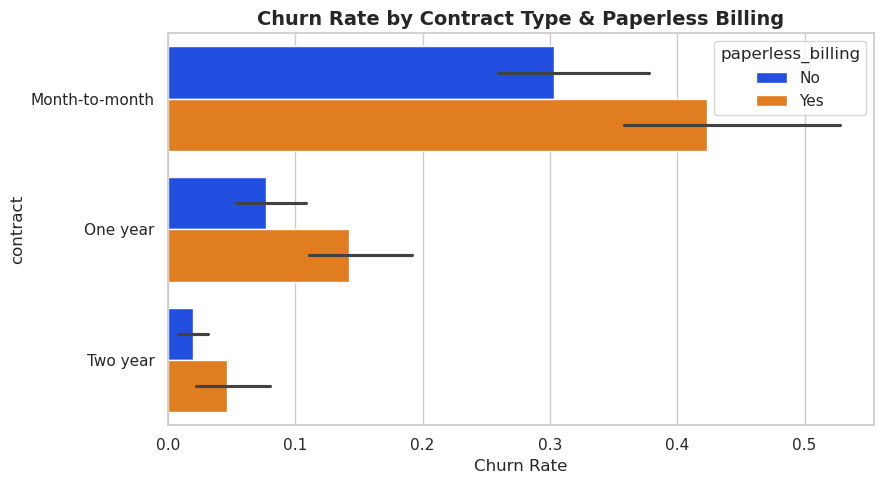

In [ ]:
# Compute churn rates by key categorical features
categorical_features =['contract', 'payment_method', 'paperless_billing']
churn_rates = (
    df_readable.groupby(categorical_features)['churn']
    .value_counts(normalize=True)
    .rename('rate')
    .reset_index()

)

# Focus only on churned rates
churn_summary = churn_rates[churn_rates['churn'] == 'Yes']

# Visualize churn by key features
plt.figure(figsize=(9, 5))
sns.barplot(
    data=churn_summary,
    x='rate',
    y='contract',
    hue='paperless_billing',
    orient='h',
    palette='bright'
)
plt.title('Churn Rate by Contract Type & Paperless Billing', fontsize=fontsize, fontweight=fontweight)
plt.xlabel('Churn Rate')

plt.tight_layout()
plt.show()


**Observations:** Contract length, billing method, and payment type remain the most influential categorical drivers of churn.
Customers with month-to-month contracts show churn rates exceeding 40%, compared to less than 10% among
those with one- or two-year contracts. Paperless billing and electronic payment methods are also associated
with higher churn rates, suggesting that customers opting for convenience-oriented digital services may
exhibit lower commitment or stronger price sensitivity.


### 4.2 Financial & Loyalty Drivers <a class="anchor" id="42-financial--loyalty-drivers"></a>

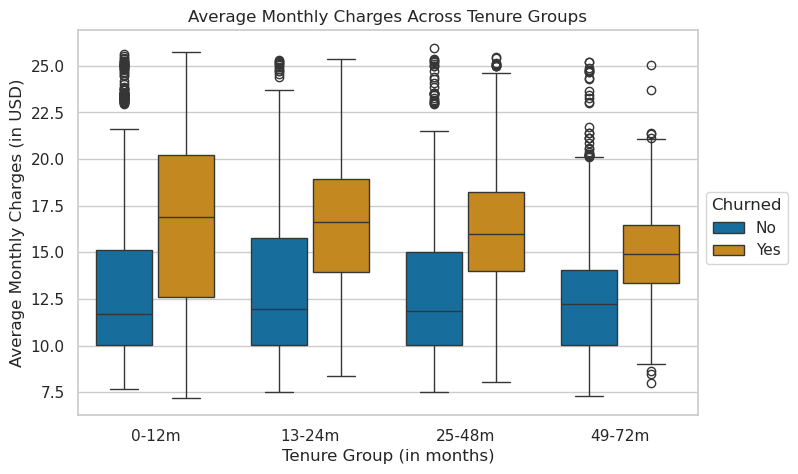

In [ ]:
# Visualize monthly charges across tenure groups
df_merged = df_readable.merge(right=df, right_index=True, left_on='customer_id', how='inner')[['tenure_group', 'monthly_charges_per_service', 'churn_x']]
df_merged.rename({'churn_x': 'churn'}, inplace=True, axis=1)

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_merged, x='tenure_group', y='monthly_charges_per_service', hue='churn', gap=0.1)
plt.title('Average Monthly Charges Across Tenure Groups')
plt.xlabel('Tenure Group (in months)')
plt.ylabel('Average Monthly Charges (in USD)')
plt.legend(title='Churned',bbox_to_anchor=(1.0, 0.6))

plt.show()

**Observations:** Long-term customers tend to have slightly higher monthly charges, reflecting either service upgrades or stable subscription patterns over time. However, the overlap across groups suggests that spending alone is not a clear predictor of loyalty. Additionally, at all tenure groups, customer retention was associated with lower average monthly charges.

Higher average monthly charges are a reasonably strong predictor on thier own, but a when considered in conjunction with newer customers, high charges correspond with greater churn likelihood — suggesting that price sensitivity is strongest early in the customer lifecycle.

### 4.3 Internet Service Drivers  <a class="anchor" id="43-internet-service-drivers"></a>

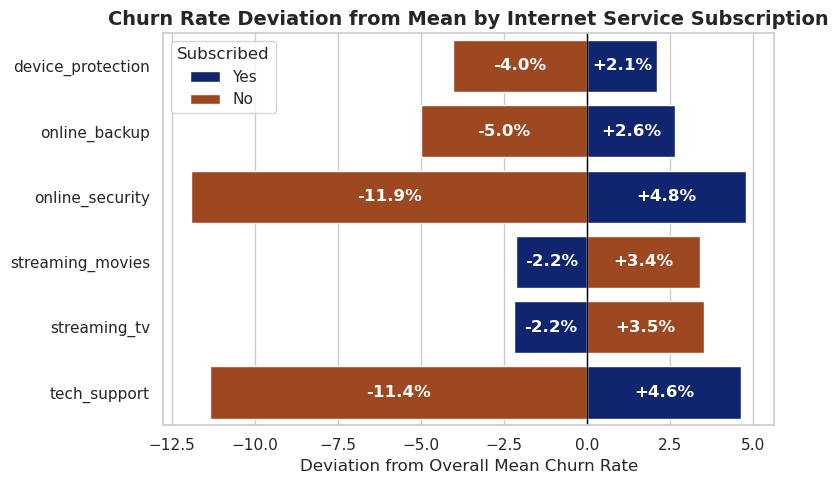

In [ ]:
# Compute churn rates per service
service_churn = (
    df.melt(id_vars='churn', value_vars=internet_services, var_name='Service', value_name='Subscribed')
    .groupby(['Service', 'Subscribed'])['churn'].mean()
    .reset_index()
)

# Remove trailing '_Yes' to improve service name clarity
service_churn['Service'] = service_churn['Service'].apply(lambda x: x[:-4])

# Compute deviations from the overall mean, calculate percentages
mean_churn = df['churn'].mean()
service_churn['Deviation'] = service_churn['churn'] - mean_churn
service_churn['Deviation'] = service_churn['Deviation'] * 100

# Create label text for annotation
service_churn['Label'] = service_churn['Deviation'].apply(
    lambda x: f"{x:+.1f}%"  # e.g. +6.2% or -12.4%
)

# Visualize the deviation barplot
plt.figure(figsize=(8,5))
barplot = sns.barplot(
    data=service_churn,
    x='Deviation', y='Service', hue='Subscribed',
    dodge=False, 
    width=0.8,
    # Set different color palette to make Subscribed visually distinct from churn rate charts
    palette='dark'
)

# Add labels on bars
barplot.bar_label(barplot.containers[0], labels=service_churn['Label'].loc[0::2], fmt='', label_type='center', color='#FFFFFF', fontweight=fontweight)
barplot.bar_label(barplot.containers[1], labels=service_churn['Label'].loc[1::2], fmt='', label_type='center', color='#FFFFFF', fontweight=fontweight)

# Add zero-line
plt.axvline(0, color='black', linewidth=1)
plt.title('Churn Rate Deviation from Mean by Internet Service Subscription', fontsize=fontsize, fontweight=fontweight)
plt.xlabel('Deviation from Overall Mean Churn Rate')
plt.ylabel('')

# Change legend labels to be more readable
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(title='Subscribed', handles=handles, labels=('Yes', 'No'))

plt.tight_layout()
plt.show()

**Observations:** Device protection and online backup appear to help with customer retention, but not as significantly as online security and tech support. Streaming services' correlation with churn rate is quantified in this chart, and although this correlation requires attention, the actual churn rate difference is comparatively low. 

### 4.4 Key Churn Drivers Summary <a class="anchor" id="44-key-churn-drivers-summary"></a>

- **Contract length** is the single most influential churn driver: customers with month-to-month plans are 3× more likely to leave than those with annual contracts.
- **Tenure** strongly moderates churn risk: retention stabilizes after ~24 months.
- **Billing preferences** such as paperless billing and electronic payments correlate with higher churn, possibly reflecting less committed or more price-sensitive customers.
- **Service complexity** (more add-on services) and **higher total charges** are modestly associated with lower churn, consistent with greater engagement; however, this is not universally true as streaming services are correlated with lower customer retention.


### 4.5 Recommendations <a class="anchor" id="45-recommendations"></a>

Based on the analysis of customer churn patterns in the Telco dataset, several actionable insights emerge that can help the company reduce churn and improve customer retention.

1. Target High-Risk Customer Segments

    Key finding: Customers on month-to-month contracts and those without paperless billing show significantly higher churn rates.

    Recommendation: Encourage longer-term contracts through loyalty discounts, bundled offers, or early renewal incentives.
    Example: Offer a 5% monthly discount for customers switching from monthly to annual contracts.

2. Focus Retention Efforts on Early-Tenure Customers

    Key finding: Churn rates are highest among customers with tenure less than one year.

    Recommendation: Develop a “first-year engagement program” — onboarding support, satisfaction surveys, or proactive service checks to strengthen early relationships.

3. Address Pain Points in Internet and Tech Support Services

    Key finding: Customers using Fiber Optic services and those reporting Tech Support = No have higher churn.

    Recommendation: Improve customer experience by ensuring fiber customers receive clear setup guidance and have easier access to tech support.

4. Optimize Pricing and Billing Transparency

    Key finding: High monthly charges correlate with higher churn, particularly among customers with additional services (streaming, online security, etc.).

    Recommendation: Offer clearer billing breakdowns or flexible service packages to reduce perceived cost concerns.

5. Leverage Predictive Monitoring (Future Opportunity)

    While this analysis focused on identifying churn drivers, the next step could be developing a churn prediction model (e.g., logistic regression) to proactively flag at-risk customers.



### 4.6 Business Impact Summary <a class="anchor" id="46-business-impact-summary"></a>

Exploratory analysis of the Telco dataset revealed key drivers of customer churn, spanning demographics, service usage, contracts, billing, and tenure.

**Primary churn drivers:**

- **Contract length:** Month-to-month customers are three times more likely to churn than long-term subscribers.

- **Tenure:** Early-stage customers (<24 months) face the highest churn risk, with retention stabilizing after two years.

- **Billing preferences:** Paperless billing and electronic payments correlate with higher churn, reflecting potential price sensitivity or lower engagement.

- **Service complexity and charges:** Customers using multiple services or paying higher total charges are modestly more loyal, though streaming services show slightly higher churn.

**Actionable insights:**

1. **Target high-risk segments** with loyalty programs or contract incentives to reduce early churn.

2. **Focus on first-year retention** via onboarding support, proactive engagement, and satisfaction monitoring.

3. **Enhance internet and tech support services** to improve customer experience, particularly for Fiber and tech support users.

4. **Optimize pricing and billing transparency** to reduce perceived cost concerns and improve perceived value.

5. **Leverage predictive monitoring** to proactively identify and retain at-risk customers.

**Projected business impact:** Implementing these strategies can reduce churn by 5-10% in high-risk segments, increase customer lifetime value, and improve overall customer satisfaction and service transparency.